In [29]:
import gymnasium as gym
import random
env_name = "LunarLander-v3"
env = gym.make(env_name, render_mode="human")


In [30]:
vec_envs = gym.make_vec(env_name, num_envs=4)
state = vec_envs.reset()

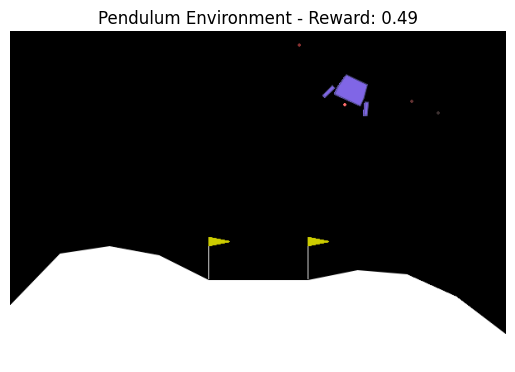

In [31]:
# visualize the environment in the notebook
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

# Create environment with rgb_array for visualization (no video recording)
env = gym.make(env_name, render_mode='rgb_array')
print("Environment created:", env)

# Reset and get initial observation
obs, info = env.reset()
print("Observation space:", obs.shape)
print("Info:", info)

# Run a random episode and display it in real-time
done = False
start_time = time.time()

# Create figure once
plt.figure(figsize=(8, 6))

while time.time() - start_time < 10:  # Run for 10 seconds
    action = env.action_space.sample()  # Random action
    obs, reward, done, truncated, info = env.step(action)
    
    # Get frame and display it
    frame = env.render()
    
    # Clear previous plot and show new frame
    clear_output(wait=True)
    plt.imshow(frame)
    plt.axis('off')
    plt.title(f'Pendulum Environment - Reward: {reward:.2f}')
    plt.show()
    
    # Reset if episode ends
    if done or truncated:
        obs, info = env.reset()
    
    time.sleep(0.05)  # Small delay to see the animation

In [44]:
env.action_space

Discrete(4)

In [48]:
vec_envs.action_space.shape

(4,)

In [32]:
from torch import nn
from torch.optim import Adam
import torch
import numpy as np
from torch.distributions import Categorical
from collections import deque
from typing import List, Tuple

def initialize_weights(layer: nn.Module):
    if isinstance(layer, nn.Linear):
        nn.init.xavier_uniform_(layer.weight)
        if layer.bias is not None:
            nn.init.zeros_(layer.bias)


class ActorCritic(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, hidden_dim: int = 128):
        super(ActorCritic, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Softmax(dim=-1)  # For discrete action spaces
        )
        self.critic = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        self.apply(initialize_weights)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        action_probs = self.actor(x)
        state_value = self.critic(x)
        return action_probs, state_value


In [33]:
def compute_gae(rewards: List[float], values: List[float], next_value: float, gamma: float = 0.99, lam: float = 0.95) -> List[float]:
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * next_value - values[step]
        gae = delta + gamma * lam * gae
        returns.insert(0, gae + values[step])
        next_value = values[step]
    return returns

def ppo_update(
    actor_critic: ActorCritic,
    optimizer: Adam,
    states: torch.Tensor,
    actions: torch.Tensor,
    old_log_probs: torch.Tensor,
    returns: torch.Tensor,
    advantages: torch.Tensor,
    clip_ratio: float = 0.2
):
    action_probs, state_values = actor_critic(states)
    
    # Calculate log probabilities
    dist = Categorical(action_probs)
    log_probs = dist.log_prob(actions)
    
    # Calculate ratios
    ratios = torch.exp(log_probs - old_log_probs)
    
    # Calculate surrogate losses
    surrogate1 = ratios * advantages
    surrogate2 = torch.clamp(ratios, 1 - clip_ratio, 1 + clip_ratio) * advantages
    
    actor_loss = -torch.min(surrogate1, surrogate2).mean() - 0.01 * dist.entropy().mean()  # Add entropy bonus for exploration
    critic_loss = nn.MSELoss()(state_values.squeeze(), returns)
    
    loss = actor_loss + critic_loss
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [38]:
vec_envs.action_space.nvec.shape

(4,)

In [64]:
# hyperparameters
learning_rate = 3e-4
input_dim = vec_envs.observation_space.shape[1]
output_dim = vec_envs.action_space.shape[0]  # For discrete action spaces
hidden_dim = 128
num_episodes = 10000
max_frames = 30_000

# Initialize actor-critic model and optimizer
actor_critic = ActorCritic(input_dim, output_dim, hidden_dim)
optimizer = Adam(actor_critic.parameters(), lr=learning_rate)


In [65]:
input_dim, output_dim

(8, 4)

In [97]:
import tqdm

def plot_rewards(rewards: List[float], title: str = "Training Rewards"):
    plt.figure(figsize=(10, 5))
    plt.plot(rewards, label='Average Reward')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()


def test_env(env, actor_critic, num_episodes: int = 10, visualize: bool = True):
    test_rewards = []
    for _ in range(num_episodes):
        state, info = env.reset()
        done = False
        truncated = False
        episode_reward = 0
        
        while not (done or truncated):
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            action_probs, _ = actor_critic(state_tensor)
            dist = Categorical(action_probs)
            action = dist.sample()
            
            next_state, reward, done, truncated, info = env.step(action.item())
            episode_reward += reward
            
            if visualize:
                frame = env.render()
                plt.imshow(frame)
                plt.axis('off')
                plt.title(f'Test Episode - Reward: {reward:.2f}')
                plt.show()
            
            state = next_state
        
        test_rewards.append(episode_reward)
    avg_reward = np.mean(test_rewards)
    print(f"Average Test Reward over {num_episodes} episodes: {avg_reward:.2f}")
    return test_rewards

def train_ppo(vec_envs, env, actor_critic, optimizer, num_episodes: int = 10000, max_frames: int = 30_000):
    frame_idx = 0
    test_rewards = []
    episode_rewards = deque(maxlen=100)
    
    for episode in tqdm.tqdm(range(num_episodes)):
        state, info = vec_envs.reset()
        done = False
        episode_reward = 0
        states, actions, rewards, values, log_probs = [], [], [], [], []
        
        next_state = state  # Initialize next_state to current state
        
        while frame_idx < max_frames:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            action_probs, value = actor_critic(state_tensor)
            dist = Categorical(action_probs)
            action = dist.sample()
            
            next_state, reward, done, truncated, info = vec_envs.step(action.cpu().numpy()[0])
            log_prob = dist.log_prob(action)
            
            states.append(state_tensor)
            actions.append(action)
            rewards.append(reward)
            values.append(value)
            log_probs.append(log_prob)
            
            state = next_state
            episode_reward += reward
            frame_idx += 1
            
        episode_rewards.append(episode_reward)
        
        # Only update if we have collected some data
        if len(states) > 0:
            # Compute GAE and returns
            _, next_value = actor_critic(torch.FloatTensor(next_state).unsqueeze(0))
            print(next_value)
            next_value = next_value.squeeze()
            returns = compute_gae(rewards, values, next_value)
            
            # Convert lists to tensors
            states_tensor = torch.cat(states)
            actions_tensor = torch.tensor(actions)
            log_probs_tensor = torch.cat(log_probs)
            returns_tensor = torch.tensor(returns).float()
            
            # Calculate advantages
            values_tensor = torch.cat(values).squeeze()
            advantages = returns_tensor - values_tensor
            
            # Update the model using PPO
            ppo_update(actor_critic, optimizer, states_tensor, actions_tensor, log_probs_tensor, returns_tensor, advantages)

        if episode % 1000 == 0:
            test_reward = test_env(env, actor_critic, num_episodes=10, visualize=False)
            test_rewards.append(np.mean(test_reward))
            avg_reward = np.mean(episode_rewards) if episode_rewards else 0
            print(f"Episode {episode}, Average Reward: {avg_reward:.2f}, Frame Index: {frame_idx}, Test Reward: {np.mean(test_reward):.2f}")    
    return test_rewards



In [98]:
# Train the PPO agent
test_rewards = train_ppo(vec_envs, env, actor_critic, optimizer, num_episodes=10000, max_frames=max_frames)
plot_rewards(test_rewards, title="PPO Training Rewards")

  0%|          | 0/10000 [00:08<?, ?it/s]

tensor([[[-0.0545],
         [-0.3460],
         [ 0.0261],
         [ 0.0156]]], grad_fn=<ViewBackward0>)


TypeError: Concatenation operation is not implemented for NumPy arrays, use np.concatenate() instead. Please do not rely on this error; it may not be given on all Python implementations.

In [68]:
state, info = vec_envs.reset()
episode_reward = 0
states, actions, rewards, values, log_probs = [], [], [], [], []

next_state = state  # Initialize next_state to current state
state_tensor = torch.FloatTensor(state).unsqueeze(0)
print("State tensor shape:", state_tensor.shape)
action_probs, value = actor_critic(state_tensor)

State tensor shape: torch.Size([1, 4, 8])


In [69]:
action_probs

tensor([[[0.1961, 0.3169, 0.2212, 0.2657],
         [0.1790, 0.3054, 0.2469, 0.2687],
         [0.1613, 0.3620, 0.2369, 0.2398],
         [0.1775, 0.3610, 0.2214, 0.2402]]], grad_fn=<SoftmaxBackward0>)

In [72]:
dist = Categorical(action_probs)
action = dist.sample()
dist, action

(Categorical(probs: torch.Size([1, 4, 4])), tensor([[1, 2, 2, 2]]))

In [84]:
action.cpu().numpy()[0]

array([1, 2, 2, 2])

In [62]:
torch.FloatTensor(state).shape

torch.Size([4, 8])

In [63]:
vec_envs.observation_space.shape

(4, 8)

In [85]:
vec_envs.action_space.sample()

array([1, 2, 2, 0])

In [86]:
vec_envs.step(action.cpu().numpy()[0])

(array([[-0.0207015 ,  1.4376045 , -0.70805174,  0.36898848,  0.02823097,
          0.22109969,  0.        ,  0.        ],
        [ 0.0130722 ,  1.4391944 ,  0.4405354 ,  0.44750464, -0.01374587,
         -0.09139954,  0.        ,  0.        ],
        [ 0.01492996,  1.378388  ,  0.5005176 , -0.48031557, -0.02251425,
         -0.17477141,  0.        ,  0.        ],
        [-0.01559029,  1.4337385 , -0.7815169 ,  0.52460545,  0.01885197,
          0.19445577,  0.        ,  0.        ]], dtype=float32),
 array([-1.49397397, -3.43256539,  1.92220309, -3.01464674]),
 array([False, False, False, False]),
 array([False, False, False, False]),
 {})